In [1]:
#si importano tutte le librerie necessarie
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pathlib

# Preparing The Data

In [2]:
#ottenimento della cartella con il nostro dataset
data_dir = pathlib.Path('C:/Users/Utente PC/Desktop/ProgettoIA/ai_course_template/data/class25')
print(data_dir)

C:\Users\Utente PC\Desktop\ProgettoIA\ai_course_template\data\class25


C:\Users\Utente PC\Desktop\ProgettoIA\ai_course_template\data\class25\0-25%\0.1.png


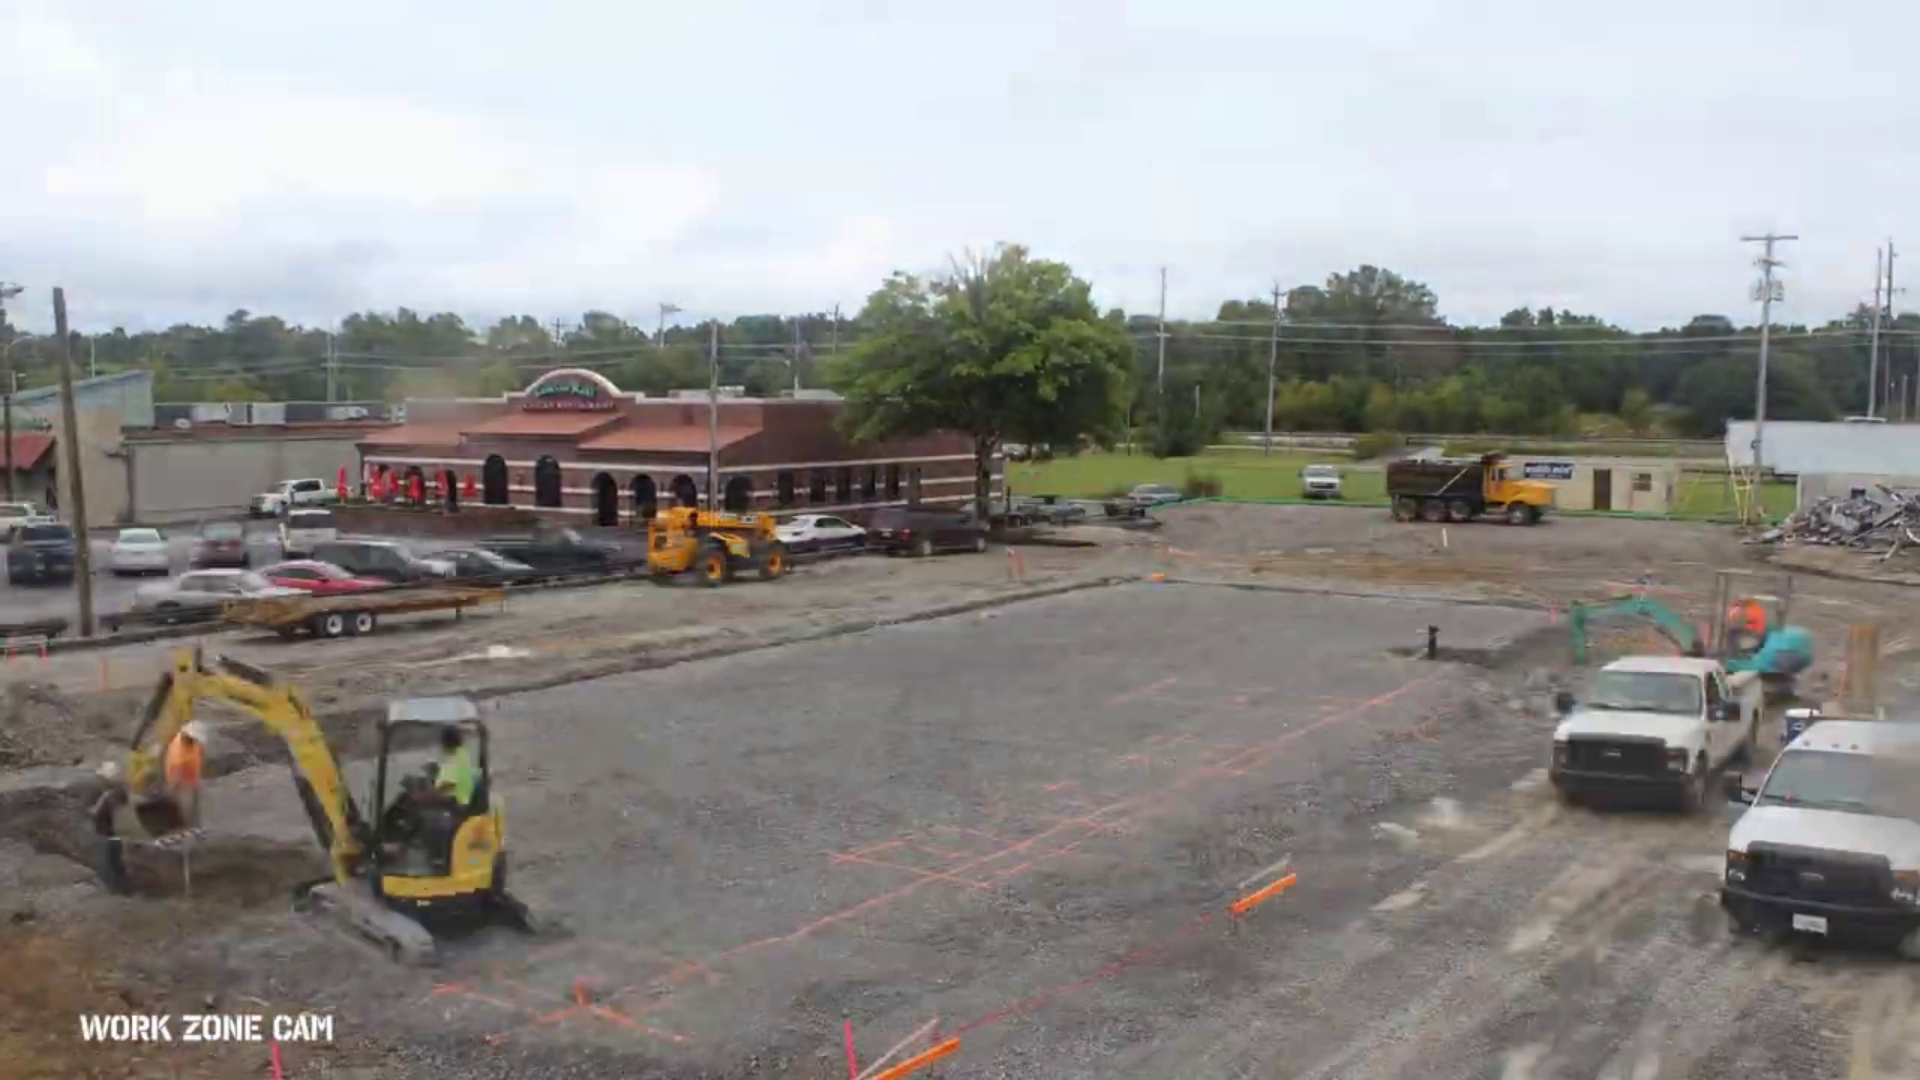

In [3]:
#test del contenuto all'interno di una cartella
images_dt = list(data_dir.glob('0-25%/*'))
print(str(images_dt[0]))
PIL.Image.open(str(images_dt[0]))

In [4]:
#set delle immagini che verranno utilizzate come training
img_height,img_width=180,180
batch_size=32  #numero di campioni di dati utilizzati in un epoca (ogni epoca addestra su tutto il dataset che viene suddiviso in vari batch)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # 20% dataset per il test
  subset="training",
  seed=123, #garantire che la suddivisione dei dati sia riproducibile
  label_mode='categorical', #le etichette vengono rappresentate in one-hot encoding (casistica di classificazione con più classi)
  image_size=(img_height, img_width),
  batch_size=batch_size)

'''In train_ds abbiamo oggetti di tipo tipo tf.data.Dataset e contengono coppie di immagini e 
relative etichette sotto forma di tensori. Le immagini in questi dataset sono rappresentate come tensori di pixel, 
dove ogni pixel può avere un valore numerico che rappresenta l'intensità del colore. Ad esempio, se l'immagine è a colori, i tensori 
saranno tensori tridimensionali, con dimensioni che rappresentano altezza, larghezza e canali di colore (solitamente 3 per RGB). 
Se l'immagine è in scala di grigi, avrà solo due dimensioni.'''

Found 1300 files belonging to 4 classes.
Using 1040 files for training.


"In train_ds abbiamo oggetti di tipo tipo tf.data.Dataset e contengono coppie di immagini e \nrelative etichette sotto forma di tensori. Le immagini in questi dataset sono rappresentate come tensori di pixel, \ndove ogni pixel può avere un valore numerico che rappresenta l'intensità del colore. Ad esempio, se l'immagine è a colori, i tensori \nsaranno tensori tridimensionali, con dimensioni che rappresentano altezza, larghezza e canali di colore (solitamente 3 per RGB). \nSe l'immagine è in scala di grigi, avrà solo due dimensioni."

In [5]:
#set delle immagini che verranno utilizzate come testing
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds_list = list(val_ds.as_numpy_iterator())

Found 1300 files belonging to 4 classes.
Using 260 files for validation.


In [7]:
#stampa delle classi trovate all'interno del dataset
class_names = train_ds.class_names
print(class_names)

['0-25%', '26-50%', '51-75%', '76-100%']


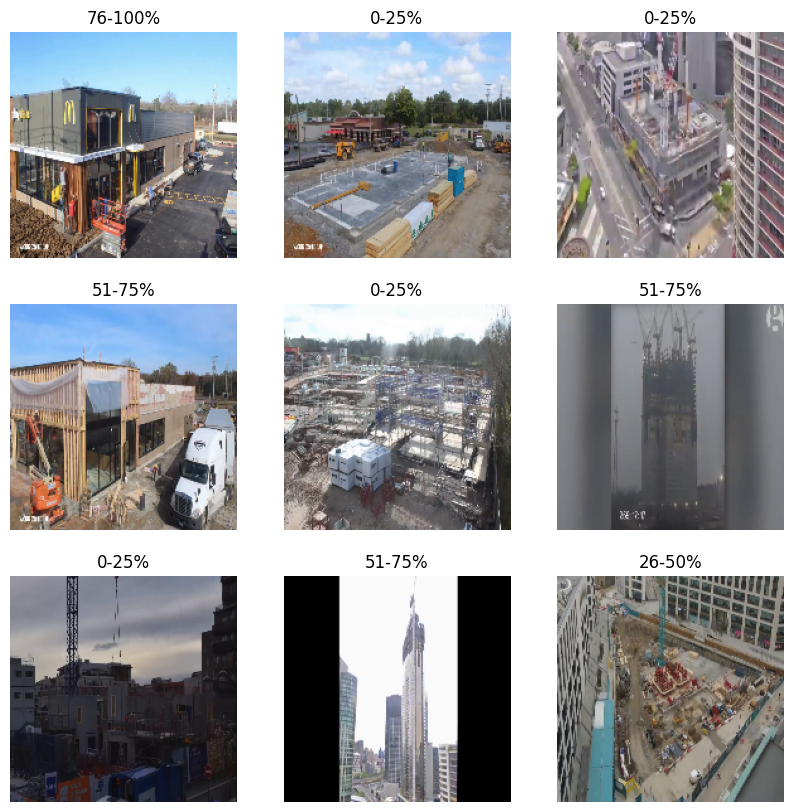

In [8]:

#esempi di immagini all'interno delle corrispettive classi
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))

      lablePos = 0
      for oneHotpos in range(len(labels[i].numpy())):
        if labels[i].numpy()[oneHotpos] == 1.0:
          lablePos = oneHotpos
          break

      plt.title(class_names[lablePos])
      plt.axis("off")


# Training The Model


In [9]:
VGG19_model = Sequential() #creazione modello sequenziale

pretrained_model= tf.keras.applications.VGG19(include_top=False, #non includere top layer che si occupano di classificazione e previsione
                   input_shape=(180,180,3),
                   pooling='avg',classes=4, #riduciamo dimensione spaziale feature map calcolando la media dei valori per ogni regione (riduciamo numero parametri e numero computazioni)
                   weights='imagenet') # permette di individuare di utilizzare dei modelli pre addestrati che sono già in grado di riconoscere degli oggetti o immagini

for layer in pretrained_model.layers: #cicla su tutti i pesi del modello pre impostati da ImageNet
        layer.trainable=False #i pesi non verranno aggiornati in fase di training

VGG19_model.add(pretrained_model) #il modello pre-addestrato diventa il primo layer del modello che stiamo definendo
VGG19_model.add(Flatten())  #aggiungo strato che trasforma l'output tridimensionale in vettore monodimensionale
VGG19_model.add(Dense(512, activation='relu')) #aggiungo layer connesso con 512 neuroni e funzione di attivazione relu (se output x del layer precedente è >0 restituisce x, se x è negativo restituisce 0)
VGG19_model.add(Dense(4, activation='softmax'))#aggiungo layer connesso con 4 neuroni (uno per classe) e funzione softmax che converte output in probabilità (definisce distribuzione probabilità tra le varie classi)

In [10]:
VGG19_model.summary() #rappresentazione testuale del modello

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 module_wrapper (ModuleWrap  (None, 512)               0         
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 512)               262656    
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 4)                 2052      
 apper)                                                          
                                                                 
Total params: 20289092 (77.40 MB)
Trainable params: 264708 (1.01 MB)
Non-trainable params: 20024384 (76.39 MB)
___________

In [11]:
VGG19_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
 #configurazione: adam è l'ottimizzatore da usare
 #definisco funzione di perdità da minimizzare (categorical crossentropy è particolarmente adatta quando si lavora con output softmax, poiché
#misura la discrepanza tra le distribuzioni delle probabilità predette e reali), la metrica da monitorare durante l'addestramento è l'accurate

In [12]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=5,restore_best_weights=True, verbose=1)

In [13]:
epochs=30 #numero di singole iterazioni nell'addestramento, ogni epoca valuta tutto il dataset
history = VGG19_model.fit( #fit è il metodo di addestramento
  train_ds, #passo il dataset per il training
  validation_data=val_ds, #passo il dataset per il testing
  epochs=epochs, #passo numero epoche
  callbacks=[earlystopping] #callback per stoppare esecuzione
)

Epoch 1/30




33/33 [==============================] - 92s 3s/step - loss: 2.7416 - accuracy: 0.5029 - val_loss: 1.0911 - val_accuracy: 0.6769
Epoch 2/30
33/33 [==============================] - 96s 3s/step - loss: 0.5432 - accuracy: 0.8096 - val_loss: 0.6007 - val_accuracy: 0.7731
Epoch 3/30
33/33 [==============================] - 101s 3s/step - loss: 0.2192 - accuracy: 0.9192 - val_loss: 0.6170 - val_accuracy: 0.7885
Epoch 4/30
33/33 [==============================] - 98s 3s/step - loss: 0.1412 - accuracy: 0.9481 - val_loss: 0.5657 - val_accuracy: 0.8000
Epoch 5/30
33/33 [==============================] - 98s 3s/step - loss: 0.0905 - accuracy: 0.9731 - val_loss: 0.5623 - val_accuracy: 0.7923
Epoch 6/30
33/33 [==============================] - 99s 3s/step - loss: 0.0721 - accuracy: 0.9827 - val_loss: 0.4984 - val_accuracy: 0.8231
Epoch 7/30
33/33 [==============================] - 98s 3s/step - loss: 0.0462 - accuracy: 0.9923 - val_loss: 0.5933 - val_accuracy: 0.7808
Epoch 8/30
33/33 [==========

# Evaluating The Model

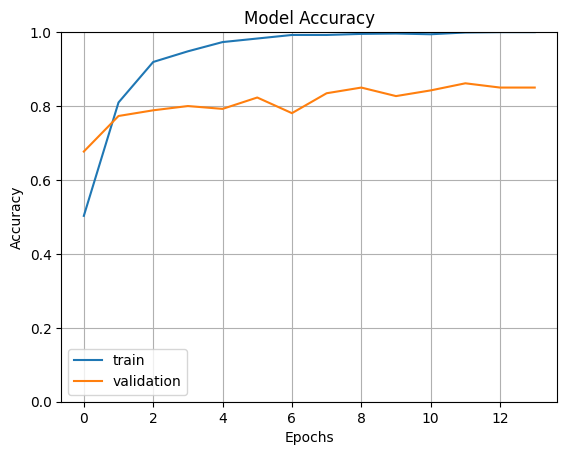

In [14]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

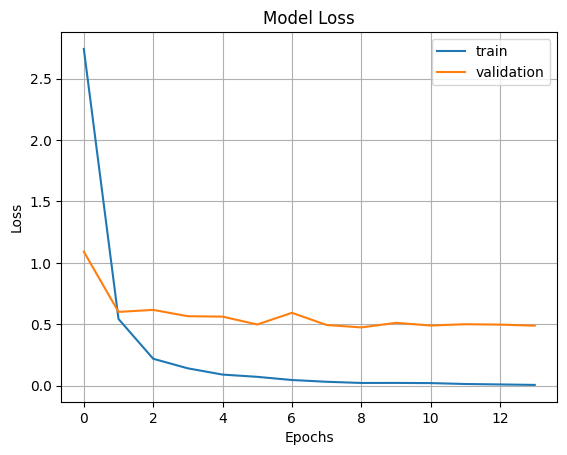

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [16]:
y_true = []          
for _,labels in val_ds_list:
    lablePos = 0
    for i in range(len(labels)):
        for oneHotpos in range(len(labels[i])):
            if labels[i][oneHotpos] == 1.0:
                lablePos = oneHotpos
                y_true.append(class_names[lablePos])
                break

print(y_true)

predictions = []
for batch_images, _ in val_ds_list:
    batch_predictions = VGG19_model.predict(batch_images)
    predictions.append(batch_predictions)

predictions = np.concatenate(predictions, axis=0)
#print(predictions)

y_test = []
for i in range(len(predictions)):
    y_test.append(class_names[np.argmax(predictions[i])])

print(y_test)

['26-50%', '51-75%', '26-50%', '76-100%', '51-75%', '26-50%', '76-100%', '26-50%', '0-25%', '26-50%', '26-50%', '51-75%', '0-25%', '26-50%', '0-25%', '0-25%', '26-50%', '51-75%', '26-50%', '26-50%', '76-100%', '76-100%', '76-100%', '26-50%', '51-75%', '26-50%', '26-50%', '26-50%', '76-100%', '76-100%', '0-25%', '51-75%', '76-100%', '76-100%', '76-100%', '26-50%', '76-100%', '26-50%', '76-100%', '0-25%', '76-100%', '76-100%', '26-50%', '76-100%', '0-25%', '76-100%', '51-75%', '26-50%', '26-50%', '26-50%', '51-75%', '51-75%', '0-25%', '76-100%', '51-75%', '0-25%', '76-100%', '26-50%', '76-100%', '26-50%', '0-25%', '26-50%', '51-75%', '26-50%', '26-50%', '76-100%', '0-25%', '76-100%', '51-75%', '51-75%', '26-50%', '76-100%', '0-25%', '0-25%', '76-100%', '26-50%', '0-25%', '0-25%', '26-50%', '26-50%', '26-50%', '0-25%', '26-50%', '0-25%', '76-100%', '51-75%', '76-100%', '26-50%', '51-75%', '0-25%', '51-75%', '26-50%', '0-25%', '26-50%', '76-100%', '26-50%', '51-75%', '0-25%', '76-100%', '0

In [17]:
class_cont = [0]*len(class_names)

for j in range(len(class_names)):
    class_perc = class_names[j]
    for x in range(len(y_true)):
        if(class_perc == y_true[x]):
            if(y_true[x] != y_test[x]):
                class_cont[j] = class_cont[j] + 1

print(class_cont)

[2, 21, 10, 6]


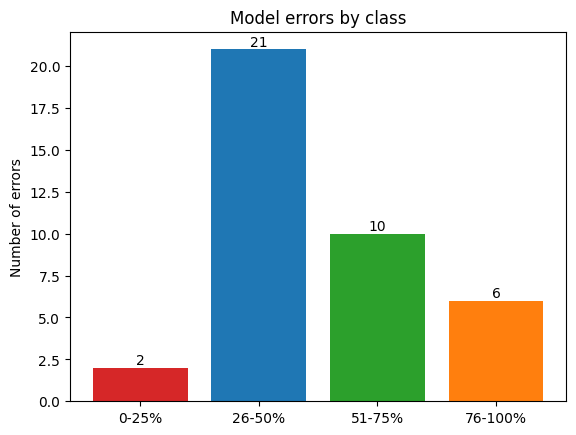

In [18]:
fig, ax = plt.subplots()

bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']

bar_container = ax.bar(class_names, class_cont, color=bar_colors)

ax.set_ylabel('Number of errors')
ax.set_title('Model errors by class')
ax.bar_label(bar_container, fmt='{:,.0f}')

plt.show()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
PartitionExplainer explainer: 5it [03:07, 46.94s/it]                       


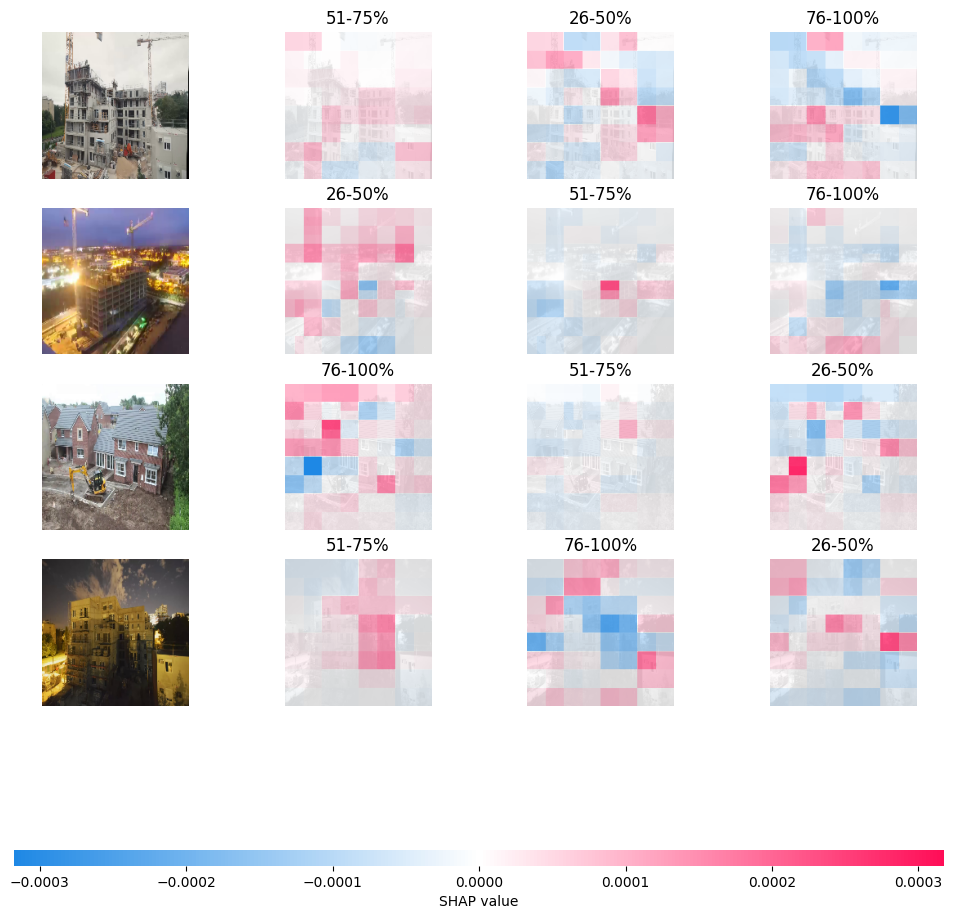

In [19]:
import json

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

import shap

# load pre-trained model and choose two images to explain
model = VGG19_model
class_names = ['0-25%','26-50%','51-75%','76-100%']

def f(test_nparray):
    tmp = test_nparray.copy()
    preprocess_input(tmp)
    return model(tmp)


#X, y = shap.datasets.imagenet50()
#print(type(X))

test = []
for images, _ in val_ds_list[0:32]:
    for i in range(len(images)):
        test.append(images[i])

test_nparray = np.array(test)
#print(test_nparray)
#print(class_names)

# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", test_nparray[0].shape)

# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we use 500 evaluations of the underlying model to estimate the SHAP values
#print(test_nparray[1:3])
#print(X[1:3])

shap_values = explainer(
    test_nparray[1:5].astype("uint8"), max_evals=500, batch_size=32, outputs=shap.Explanation.argsort.flip[:3]
)
shap.image_plot(shap_values)


In [15]:
VGG19_model.save('VGG19(class25)')

INFO:tensorflow:Assets written to: VGG19(class25)\assets


INFO:tensorflow:Assets written to: VGG19(class25)\assets
